<a href="https://colab.research.google.com/github/JonahFlateman/dsc-project-template/blob/master/mod4_project-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start by using surprise to test some simple models.

In [2]:
import pandas as pd
df = pd.read_csv('/content/ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43084 entries, 0 to 43083
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     43084 non-null  int64  
 1   movieId    43084 non-null  int64  
 2   rating     43084 non-null  float64
 3   timestamp  43083 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.3 MB


In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703.0
1,1,3,4.0,964981247.0
2,1,6,4.0,964982224.0
3,1,47,5.0,964983815.0
4,1,50,5.0,964982931.0


In [10]:
rating_counts = df['rating'].value_counts()
sorted_counts = {k:v for k, v in sorted(rating_counts.items(), key=lambda x: x[1])}
sorted_count = list(sorted_counts.items())
x = [item[0] for item in sorted_count]
y = [item[1] for item in sorted_count]

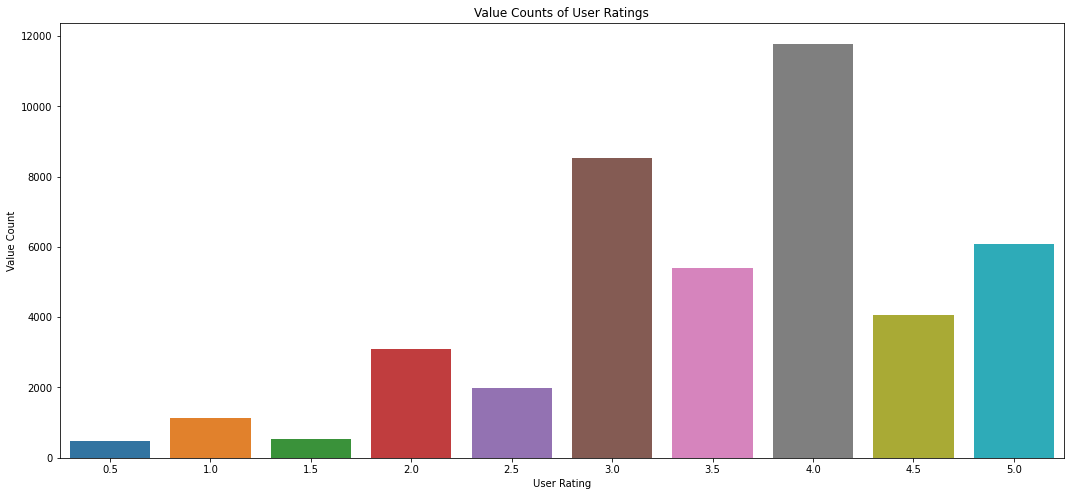

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(18,8))
sns.barplot(x=x, y=y)
plt.title('Value Counts of User Ratings')
plt.xlabel('User Rating')
plt.ylabel('Value Count')
plt.show()

In [ ]:
# Drop unnecessary columns
new_df = df.drop(columns='timestamp')

Using Reader and Dataset classes to transform dataset for surprise compatability.

In [ ]:
!pip install surprise
from surprise import Reader, Dataset
# read in values as Surprise dataset
reader = Reader()
data = Dataset.load_from_df(new_df, reader)

     |████████████████████████████████| 11.8 MB 51 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617755 sha256=f663b0f8a33e06965dcbbc409370a3ca820d2e46c05720c52aa41201fe497186
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


Determine the best model.

In [ ]:
# importing relevant libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

In [ ]:
## Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
params = {'n_factors': [25, 50, 100],
         'reg_all': [.02, .05, .1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [ ]:
# print out optimal parameters for SVD after GridSearch
g_s_svd.best_params

{'mae': {'n_factors': 100, 'reg_all': 0.05},
 'rmse': {'n_factors': 100, 'reg_all': 0.05}}

In [ ]:
g_s_svd.best_score

{'mae': 0.6683300028345278, 'rmse': 0.869192261893539}

In [ ]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options ={'name': 'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [ ]:
for i in cv_knn_basic.items():
    print(i)

('test_rmse', array([0.9739547 , 0.97097203, 0.98115596, 0.96838372, 0.97131969]))
('test_mae', array([0.75145516, 0.74926024, 0.75540386, 0.74974945, 0.75132907]))
('fit_time', (0.7373204231262207, 0.7881269454956055, 0.7386050224304199, 0.8087260723114014, 0.4578678607940674))
('test_time', (2.4968807697296143, 2.404313087463379, 2.5085268020629883, 2.414485454559326, 1.29105544090271))


In [ ]:
# print out the average RMSE score for the test set
print(np.mean(cv_knn_basic['test_rmse']))

0.9731572199754336


In [ ]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options ={'name': 'pearson', 'user_based': True})
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs=-1)

In [ ]:
# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)

('test_rmse', array([0.87458429, 0.87215231, 0.88008978, 0.87547632, 0.88127783]))
('test_mae', array([0.67042312, 0.66404346, 0.67430874, 0.67003686, 0.67111157]))
('fit_time', (0.8522236347198486, 1.1409227848052979, 1.1644933223724365, 1.484827995300293, 0.846437931060791))
('test_time', (4.175719261169434, 3.9973037242889404, 3.9616451263427734, 3.3830652236938477, 2.019829273223877))


In [ ]:
print(np.mean(cv_knn_baseline['test_rmse']))

0.8767161054193723


The best model is SVD with n_factors=50 and regularization rate of 0.05.

Let's make recommendations using movie titles.

In [ ]:
df_movies = pd.read_csv('/content/movies.csv')

In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
svd = SVD(n_factors=100, reg_all=0.05)
svd.fit(dataset)

In [ ]:
svd.predict(3, 6)

Prediction(uid=3, iid=6, r_ui=None, est=2.9374889545502123, details={'was_impossible': False})

In [ ]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie['title'])
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [ ]:
movie_rater(df_movies, 5, 'Adventure')

8964    God Loves Caviar (2012)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
4795    Last Samurai, The (2003)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
6580    Into the Wild (2007)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
8963    Batman v Superman: Dawn of Justice (2016)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
8114    Journey to the West: Conquering the Demons (Da...
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3


[{'movieId': 136912, 'rating': '3', 'userId': 1000},
 {'movieId': 7143, 'rating': '4', 'userId': 1000},
 {'movieId': 55247, 'rating': '5', 'userId': 1000},
 {'movieId': 136864, 'rating': '3', 'userId': 1000},
 {'movieId': 100882, 'rating': '3', 'userId': 1000}]

In [ ]:
user_rating = movie_rater(df_movies, 5, 'Adventure')

2253    Licence to Kill (1989)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
9219    Embrace of the Serpent (2016)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2
6886    Quantum of Solace (2008)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
5586    Stand, The (1994)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
7409    Machete (2010)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4


In [ ]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = new_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [ ]:
# train a model using the new combined DataFrame
svd = SVD(n_factors=50, reg_all=0.05)
svd.fit(new_data.build_full_trainset())

In [ ]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in new_df['movieId'].unique():
    list_of_movies.append((m_id, svd.predict(1000, m_id)[3]))

In [ ]:
# order the predictions from highest to lowest rated

ranked_movies = sorted(list_of_movies, key=lambda x: x[1], reverse=True)

In [ ]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation #', idx+1, ': ', title, '\n')
            n -=1
            if n == 0:
                break
            
recommended_movies(ranked_movies,df_movies,5)

Recommendation # 1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation # 2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation # 3 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation # 4 :  2226    Fight Club (1999)
Name: title, dtype: object 

Recommendation # 5 :  863    Monty Python and the Holy Grail (1975)
Name: title, dtype: object 



In [ ]:

!apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [ ]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession

# instantiate SparkSession object
spark = SparkSession.builder.master("local").getOrCreate()

In [ ]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('/content/ratings.csv', header='true', inferSchema='true')

In [ ]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select("rating").count()

    # Count the number of distinct userIds and distinct movieIds
    total_elements = ratings.select("userId").distinct().count() * ratings.select("movieId").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")
    
get_mat_sparsity(movie_ratings)

The ratings dataframe is  98.30% sparse.


In [ ]:
# Group data by userId, count ratings
userId_ratings = movie_ratings.groupBy("userId").count().orderBy('count', ascending=False)
userId_ratings.show()

+------+-----+
|userId|count|
+------+-----+
|   414| 2698|
|   599| 2478|
|   474| 2108|
|   448| 1864|
|   274| 1346|
|   610| 1302|
|    68| 1260|
|   380| 1218|
|   606| 1115|
|   288| 1055|
|   249| 1046|
|   387| 1027|
|   182|  977|
|   307|  975|
|   603|  943|
|   298|  939|
|   177|  904|
|   318|  879|
|   232|  862|
|   480|  836|
+------+-----+
only showing top 20 rows



In [ ]:
# Group data by userId, count ratings
movieId_ratings = movie_ratings.groupBy("movieId").count().orderBy('count', ascending=False)
movieId_ratings.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|     50|  204|
|   2858|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



In [ ]:
movie_ratings.dtypes

[('userId', 'int'),
 ('movieId', 'int'),
 ('rating', 'double'),
 ('timestamp', 'int')]

In [ ]:
movie_ratings = movie_ratings.drop('timestamp')

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS 

# split into training and testing sets
(training, test) = movie_ratings.randomSplit([.8, .2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

# fit the ALS model to the training set
model=als.fit(training)

In [ ]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(rmse)

0.9728398955299705


In [ ]:
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   597|    471|   2.0|  4.001458|
|   385|    471|   4.0| 3.2350755|
|   599|    471|   2.5|  2.712304|
|   520|    471|   5.0| 3.3077674|
|   216|    471|   3.0| 3.4027748|
|   469|    471|   5.0| 3.5870197|
|   492|    833|   4.0|  2.072132|
|   463|   1088|   3.5| 3.0783813|
|   599|   1088|   2.5| 2.4755034|
|   594|   1088|   4.5| 4.2686963|
|    84|   1088|   3.0| 3.2118673|
|   188|   1088|   4.0| 3.5370748|
|    68|   1088|   3.5| 3.3403766|
|   483|   1088|   3.0| 3.0670218|
|   587|   1238|   4.0| 3.4128103|
|   325|   1238|   4.0| 4.2032304|
|   156|   1238|   4.0| 3.8865485|
|    19|   1342|   2.0|  2.297449|
|   137|   1580|   3.5|  3.200812|
|   593|   1580|   1.5| 2.7449996|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
#als_model = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid              
#params = ParamGridBuilder().addGrid(als_model.regParam, [.01, .05, .1, .15]).addGrid(als_model.rank, [10, 50, 100, 150]).build()

# instantiating crossvalidator estimator
#cv = CrossValidator(estimator=als_model, estimatorParamMaps=params, evaluator=evaluator, parallelism=4)
#best_model = cv.fit(movie_ratings)

50

In [ ]:
#model = best_model.bestModel

In [ ]:

# Print best_model
#print(type(model))

# Complete the code below to extract the ALS model parameters
#print("**Best Model**")

# # Print "Rank"
#print("  Rank:", model._java_obj.parent().getRank())

# Print "MaxIter"
#print("  MaxIter:", model._java_obj.parent().getMaxIter())

# Print "RegParam"
#print("  RegParam:", model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 50
  MaxIter: 10
  RegParam: 0.15


In [ ]:
final_als = ALS(maxIter=10, rank=50, regParam=0.15, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
final_model = final_als.fit(training)

In [ ]:
test_predictions = final_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8690776508705221


In [ ]:
movie_titles = spark.read.csv('movies.csv', header='true', inferSchema='true')

movie_titles.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [ ]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [ ]:
print(name_retriever(1022, movie_titles))

Cinderella (1950)


In [ ]:
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [ ]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

'Farewell My Concubine (Ba wang bie ji) (1993)'

In [ ]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=4248, rating=8.758819580078125), Row(movieId=3223, rating=7.480904579162598), Row(movieId=99764, rating=7.315658092498779), Row(movieId=93563, rating=6.8287787437438965), Row(movieId=1468, rating=6.746992111206055)])]

In [ ]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
  new_user_ratings = spark.createDataFrame(new_ratings, rating_df.columns)
    
    # combine the new ratings df with the rating_df
  movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # create an ALS model and fit it
  als = ALS(maxIter=10, rank=50, regParam=0.15, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
  model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
  recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
  recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)

  for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
    movie_string = name_retriever(movie_id, movie_title_df)
    print('Recommendation {}: {} | predicted score: {}'.format(ranking+1, movie_string, rating))

In [ ]:
# try out your function with the movies listed above
user_id = 1000
user_ratings_1 = [(user_id, 3000, 5), (user_id, 2500, 5), (user_id, 2000, 4), (user_id, 1757, 6)]
new_user_recs(user_id, user_ratings_1, movie_ratings, movie_titles, 10)

Recommendation 1: Fallen Angels (Duo luo tian shi) (1995) | predicted score: 5.992415428161621
Recommendation 2: Clockwork Orange, A (1971) | predicted score: 5.332775115966797
Recommendation 3: Hustler, The (1961) | predicted score: 5.221590518951416
Recommendation 4: Manhattan (1979) | predicted score: 5.212000846862793
Recommendation 5: Monty Python and the Holy Grail (1975) | predicted score: 5.210682392120361
Recommendation 6: Blue Velvet (1986) | predicted score: 5.173949718475342
Recommendation 7: L.A. Confidential (1997) | predicted score: 5.124312400817871
Recommendation 8: Seven Samurai (Shichinin no samurai) (1954) | predicted score: 5.099935531616211
Recommendation 9: Ran (1985) | predicted score: 5.080130100250244
Recommendation 10: Godfather, The (1972) | predicted score: 5.003494739532471
